In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model (ORM Class)
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [9]:
#inspect the engine
inspector=inspect(engine)

In [10]:
#collect the names of the tables

inspector.get_table_names()



['measurement', 'station']

In [11]:
#looking at the column names and types 'measurement' table
columns_m=inspector.get_columns('measurement')
for column in columns_m:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#looking at the columns names and types in 'station' table
columns_s=inspector.get_columns('station')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#Looking at the data for 'measurement'
results=engine.execute ('select * from Measurement limit 5')
for result in results:
        print(result)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [14]:
#Looking at the data for 'station'
results=engine.execute ('select * from Station limit 5')
for result in results:
        print(result)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
most_recent=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]


print(most_recent)
type(most_recent)

2017-08-23


str

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. (previous cell)

#convert most recent date to datetime format, now called dt_most_recent
dt_most_recent= dt.datetime.strptime(most_recent, "%Y-%m-%d")
dt_most_recent

datetime.datetime(2017, 8, 23, 0, 0)

In [17]:
# Calculate the date one year from the last date in data set.
dt_first_date=dt_most_recent-dt.timedelta(days=365)
dt_first_date

datetime.datetime(2016, 8, 23, 0, 0)

In [18]:
# Perform a query to retrieve the data and precipitation scores
precip_query=(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>dt_first_date).order_by(Measurement.date).all())

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df=pd.DataFrame(precip_query,columns= ["Date", "Precipitation"])
precip_df["Date"] = pd.to_datetime(precip_df["Date"])
precip_df= precip_df.sort_values("Date").dropna().set_index("Date")
precip_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


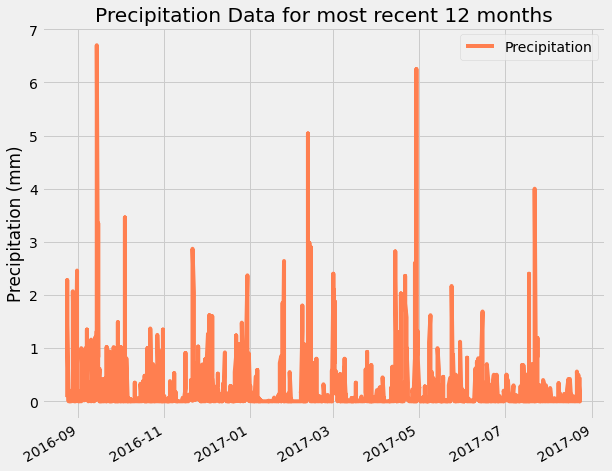

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(color="coral", figsize=(9, 8))
plt.title("Precipitation Data for most recent 12 months")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")
plt.savefig("Images/precip.png")

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station).count()
print(stations)

9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
ma_stations = (session.query(Measurement.station, Station.name, func.count(Measurement.id))\
                .filter(Measurement.station == Station.station)\
                .group_by (Measurement.station)\
                .order_by (func.count(Measurement.id).desc())\
                .all()
              )
pprint(ma_stations)

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ma_station_data = (
    session.query(
        func.min(Measurement.tobs),\
        func.max(Measurement.tobs),\
        func.avg(Measurement.tobs),\
    )
    .filter(Measurement.station == ma_stations[0][0])
    .all()
)

ma_station_data

[(54.0, 85.0, 71.66378066378067)]

In [24]:
print(f"The most active station with the most measurements is station {ma_stations[0][0]} in {ma_stations[0][1]}.")
print(f"The lowest observed temperature for the most recent year was {ma_station_data[0][0]} deg F.")
print(f"The highest observed temperature for the most recent year was {ma_station_data[0][1]} deg F.")
print(f"The average of all observed temperatures for the most recent year was {ma_station_data[0][2]} deg F.")

The most active station with the most measurements is station USC00519281 in WAIHEE 837.5, HI US.
The lowest observed temperature for the most recent year was 54.0 deg F.
The highest observed temperature for the most recent year was 85.0 deg F.
The average of all observed temperatures for the most recent year was 71.66378066378067 deg F.


In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and
query_data= (
    session.query(Measurement.date, Measurement.tobs) #creating the query on measurement dates and measurement te
    .filter(Measurement.date > dt_first_date)   #only look at the last 12 months
    .filter(Measurement.station == ma_stations[0][0]) #most active stations
    .order_by(Measurement.date)
    .all()
)
pprint(query_data)

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

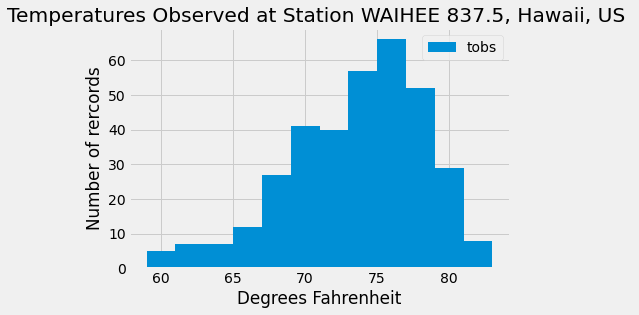

In [36]:
#convert session data to dataframe 

query_data_df=pd.DataFrame(data=query_data, columns= ["date", "tobs"])
query_data_df=query_data_df.set_index('date', drop=True)


#plot the results as a histogram

plt.hist(query_data_df,bins=12,label="tobs")
plt.tight_layout()
plt.ylabel('Number of rercords')
plt.xlabel('Degrees Fahrenheit')
plt.title('Temperatures Observed at Station WAIHEE 837.5, Hawaii, US ')
plt.legend(loc='upper right')
plt.savefig('images/station-histogram.png')
plt.show()




# Close session

In [37]:
# Close Session
session.close()